In [82]:
import pandas as pd
from pyqubo import Constraint, Array
import neal
from dwave.system import DWaveSampler, EmbeddingComposite, LeapHybridBQMSampler,  LeapHybridSampler
import dimod
import os
from dotenv import load_dotenv

In [83]:
# loading in the D-Wave Token
load_dotenv()
token_use = os.getenv("API_TOKEN")

In [84]:
data = pd.read_excel("data.xlsx")

In [85]:
columns = ["name", "position", "value", "total_points", "team", "points_per_game"]

In [86]:
data = data[columns]

In [87]:
df_use = data.sort_values("position").reset_index(drop=True)

In [88]:
for i in range(len(df_use)):
    df_use.loc[i, "variable"] = "x[" + str(i) + "]"
df_use

,name,position,value,total_points,team,points_per_game,variable
0,Vitalii Mykolenko,DEF,46,85,Everton,3.869499,x[0]
1,Dan Burn,DEF,44,74,Newcastle,3.790552,x[1]
2,Oleksandr Zinchenko,DEF,50,86,Arsenal,5.423966,x[2]
3,Benjamin White,DEF,56,119,Arsenal,5.242291,x[3]
4,Nathan Aké,DEF,51,82,Man City,4.513761,x[4]
5,Kieran Trippier,DEF,68,108,Newcastle,4.493759,x[5]
6,Gabriel dos Santos Magalhães,DEF,53,103,Arsenal,4.448177,x[6]
7,Trent Alexander-Arnold,DEF,85,103,Liverpool,5.715166,x[7]
8,Joe Gomez,DEF,46,65,Liverpool,4.326923,x[8]
9,Cristian Romero,DEF,51,87,Spurs,4.350000,x[9]


In [89]:
len(df_use["team"].unique())

16

In [90]:
defense_list_index = list(df_use[df_use["position"]=="DEF"].index)
forward_list_index = list(df_use[df_use["position"]=="FWD"].index)
gk_list_index = list(df_use[df_use["position"]=="GK"].index)
midfield_list_index = list(df_use[df_use["position"]=="MID"].index)

In [91]:
columns = ["variable","name", "position", "value", "total_points", "team", "points_per_game"]

In [92]:
total_points = df_use["points_per_game"].to_list()
value = df_use["value"].to_list()

In [93]:
df_use = df_use[columns]

In [94]:
max(df_use["value"])

144

In [95]:
lagrange = max(df_use["points_per_game"])*15
lagrange_budget = max(df_use["value"])*15
lagrange_team = max(df_use["points_per_game"])*3
num_var = len(df_use)
slack_num = 1

In [96]:
defense=4
midfield=4
forward=2

In [97]:
x = Array.create('x', shape=num_var, vartype='BINARY')
s = Array.create('s', shape=slack_num + len(df_use["team"].unique()), vartype='BINARY')

In [98]:
team_list = list(df_use["team"].unique())
team_list

['Everton',
 'Newcastle',
 'Arsenal',
 'Man City',
 'Liverpool',
 'Spurs',
 'Bournemouth',
 'Brentford',
 'Chelsea',
 'Man Utd',
 'Wolves',
 'Crystal Palace',
 'Luton',
 'Aston Villa',
 'Brighton',
 'West Ham']

In [99]:
list(df_use[df_use["team"]==team_list[0]].index)

[0]

In [100]:
# objective function
h = sum(n * x for x, n in zip(x, total_points))

# constraints
c1 = lagrange * Constraint((sum(x[n] for n in range(0, num_var)) - 15)**2,
                                                label='15 players squad')
c2 = lagrange * Constraint((sum(x[n] for n in range(min(defense_list_index), max(defense_list_index)+1))-5)**2,
                                                label=str(5) + " defenders")
c3 = lagrange * Constraint((sum(x[n] for n in range(min(forward_list_index), max(forward_list_index)+1))-3)**2,
                                                label=str(3) + " forwards")
c4 = lagrange * Constraint((sum(x[n] for n in range(min(gk_list_index), max(gk_list_index)+1))-2)**2,
                                                label= "2 keepers")
c5 = lagrange * Constraint((sum(x[n] for n in range(min(midfield_list_index), max(midfield_list_index)+1))-5)**2,
                                                label=str(5) + " midfielders")
c6 = lagrange_budget * Constraint((sum(n * x for x, n in zip(x, value)) + s[0] -1000)**2,
                                                              label="Budget")

c7 = 0

for i in range(len(team_list)):
    use_index =list(df_use[df_use["team"]==team_list[i]].index)
    c7 += lagrange_team * Constraint((sum(x[n] for n in use_index) + s[i+1] - 3)**2, label = str(team_list[i]) + " selection")

In [101]:
H = -1 * h + c1 + c2 + c3 + c4 + c5 + c6 + c7

In [102]:
model = H.compile()
qubo, offset = model.to_qubo()
bqm = model.to_bqm()

# Solve problem with QPU
api_token = token_use
sampler = LeapHybridSampler(token= api_token)
sampleset = sampler.sample(bqm,
                            label="FPL line-up optimization")

In [103]:
# Decode samples and select the best one
decoded_samples = model.decode_sampleset(sampleset)
best_sample = min(decoded_samples, key=lambda x: x.energy)

# Print to see if constraints are fulfilled
print(best_sample.constraints())

{'Brentford selection': (False, 4.0), 'Wolves selection': (False, 1.0), 'Everton selection': (False, 1.0), 'Aston Villa selection': (False, 1.0), 'Newcastle selection': (False, 1.0), 'Liverpool selection': (True, 0.0), '5 midfielders': (False, 1.0), '15 players squad': (False, 1.0), 'Brighton selection': (False, 1.0), 'Chelsea selection': (False, 4.0), 'Spurs selection': (True, 0.0), 'Crystal Palace selection': (False, 4.0), '2 keepers': (True, 0.0), 'Man Utd selection': (False, 1.0), 'Luton selection': (False, 4.0), 'Arsenal selection': (True, 0.0), 'Man City selection': (False, 1.0), 'Bournemouth selection': (False, 4.0), 'West Ham selection': (False, 4.0), 'Budget': (True, 0.0), '5 defenders': (True, 0.0), '3 forwards': (True, 0.0)}


In [104]:
# Print results for best line-up
lineup_df = pd.DataFrame(best_sample.sample.items())
lineup_df.columns = ['variable', 'selected']
lineup_df = lineup_df[(lineup_df['variable'].str.startswith(
    'x', na=False)) & (lineup_df['selected'] == 1)]
lineup_df = df_use.merge(lineup_df, on=['variable'])

# Obtain starting line-up
gk = lineup_df[lineup_df["position"] == "GK"].sort_values("points_per_game", ascending=False).head(1)
defense_list = lineup_df[lineup_df["position"] == "DEF"].sort_values("points_per_game", ascending=False).head(defense)
midfield_list = lineup_df[lineup_df["position"] == "MID"].sort_values("points_per_game", ascending=False).head(midfield)
attack_list = lineup_df[lineup_df["position"] == "FWD"].sort_values("points_per_game", ascending=False).head(forward)
start_lineup_df = pd.concat([gk, defense_list, midfield_list, attack_list], axis=0).reset_index(drop=True)
start_lineup_df = start_lineup_df[["name", "position", "value", "points_per_game", "total_points", "team"]]

# Obtain bench players
gk = lineup_df[lineup_df["position"] == "GK"].sort_values("points_per_game", ascending=False).tail(1)
defense_list = lineup_df[lineup_df["position"] == "DEF"].sort_values("points_per_game", ascending=False).tail(5-defense)
midfield_list = lineup_df[lineup_df["position"] == "MID"].sort_values("points_per_game", ascending=False).tail(5-midfield)
attack_list = lineup_df[lineup_df["position"] == "FWD"].sort_values("points_per_game", ascending=False).tail(3-forward)
bench_lineup_df = pd.concat([gk, defense_list, midfield_list, attack_list], axis=0).reset_index(drop=True)
bench_lineup_df = bench_lineup_df[["name", "position", "value", "points_per_game", "total_points", "team"]]

print("Starting Lineup")
print(start_lineup_df)
print("\n\n")
print("Bench")
print(bench_lineup_df)
print("Total starting line up sum of points: ", start_lineup_df['points_per_game'].sum())
print("Total squad budget: ", lineup_df['value'].sum())

Starting Lineup
                      name position  value  points_per_game  total_points  \
0        David Raya Martin       GK     50         3.954545            87   
1   Trent Alexander-Arnold      DEF     85         5.715166           103   
2           Benjamin White      DEF     56         5.242291           119   
3                Joe Gomez      DEF     46         4.326923            65   
4           William Saliba      DEF     58         4.148148           112   
5            Son Heung-min      MID    100         7.609461           168   
6           James Maddison      MID     80         6.051502            94   
7           Hwang Hee-chan      MID     55         5.840544           105   
8              Pascal Groß      MID     66         5.598492           132   
9           Erling Haaland      FWD    144         7.565502           154   
10           Ollie Watkins      FWD     90         6.789028           187   

           team  
0       Arsenal  
1     Liverpool  
2    

In [105]:
start_lineup_df["name"].tolist()

['David Raya Martin',
 'Trent Alexander-Arnold',
 'Benjamin White',
 'Joe Gomez',
 'William Saliba',
 'Son Heung-min',
 'James Maddison',
 'Hwang Hee-chan',
 'Pascal Groß',
 'Erling Haaland',
 'Ollie Watkins']

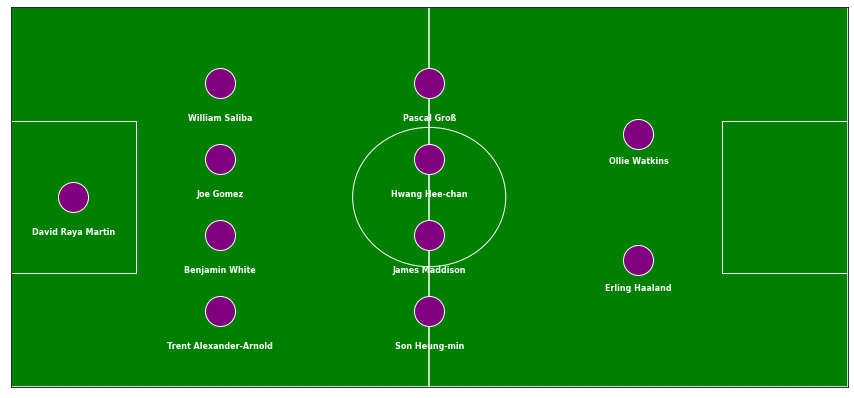

In [106]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def draw_soccer_field():
    """
    Draws a detailed soccer field with a green background, complete middle circle,
    and 18-yard boxes.
    """
    # Create figure
    fig, ax = plt.subplots(figsize=(15, 7))
    ax.set_facecolor('green')  # Set the background color to green

    # Draw the pitch outline
    plt.plot([0, 0, 200, 200, 0], [0, 100, 100, 0, 0], color="white")

    # Draw the middle line
    plt.plot([100, 100], [0, 100], color="white")

    # Draw the complete middle circle
    center_circle = patches.Circle((100, 50), 9.15, edgecolor="white", facecolor="none")
    #ax.add_patch(center_circle)

    # Draw the D-box arcs
    left_arc = patches.Arc((100, 50), height=36.6, width=18.3*2, angle=0, theta1=270, theta2=90, color="white")
    right_arc = patches.Arc((50*2, 25*2), height=18.3*2, width=18.3*2, angle=0, theta1=90, theta2=270, color="white")
    ax.add_patch(left_arc)
    ax.add_patch(right_arc)

    # Draw the 18-yard boxes
    # Left 18-yard box (from the perspective of the viewer)
    ax.add_patch(patches.Rectangle((0, 15*2), 15*2, 20*2, edgecolor="white", facecolor="none"))
    # Right 18-yard box
    ax.add_patch(patches.Rectangle(((100-15)*2, 15*2), 15*2, 20*2, edgecolor="white", facecolor="none"))

    # Set limits and turn off axis
    plt.xlim(0, 100*2)
    plt.ylim(0, 50*2)
    #plt.axis('off')
    # Remove the tick labels
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # Remove the ticks
    ax.set_xticks([])
    ax.set_yticks([])


    return fig, ax

def plot_formation(line_up):
    """
    Plots the given formation on a detailed soccer field.
    """
    fig, ax = draw_soccer_field()
    
    gk_names = line_up[line_up["position"]=="GK"]["name"].to_list()
    def_names = line_up[line_up["position"]=="DEF"]["name"].to_list()
    mid_names = line_up[line_up["position"]=="MID"]["name"].to_list()
    fwd_names = line_up[line_up["position"]=="FWD"]["name"].to_list()
    
    ax.plot(15, 50, 'o', markersize=30, color="purple", markeredgecolor="white")  # Player icon
    ax.text(15, 50 - 8, gk_names[0], ha="center", va="top", color="white", fontsize=8, fontweight="bold")  # Player name
    
    def_len = len(def_names)
    def_num = list(np.linspace(0, 100, def_len+2))[1:-1]
    for i in range(len(def_num)):
        ax.plot(50, def_num[i], 'o', markersize=30, color="purple", markeredgecolor="white")  # Player icon
        ax.text(50, def_num[i] - 8, def_names[i], ha="center", va="top", color="white", fontsize=8, fontweight="bold")  # Player name
        
    mid_len = len(mid_names)
    mid_num = list(np.linspace(0, 100, mid_len+2))[1:-1]
    for i in range(len(mid_num)):
        ax.plot(100, mid_num[i], 'o', markersize=30, color="purple", markeredgecolor="white")  # Player icon
        ax.text(100, mid_num[i] - 8, mid_names[i], ha="center", va="top", color="white", fontsize=8, fontweight="bold")  # Player name

    fwd_len = len(fwd_names)
    fwd_num = list(np.linspace(0, 100, fwd_len+2))[1:-1]
    for i in range(len(fwd_num)):
        ax.plot(150, fwd_num[i], 'o', markersize=30, color="purple", markeredgecolor="white")  # Player icon
        ax.text(150, fwd_num[i] - 6, fwd_names[i], ha="center", va="top", color="white", fontsize=8, fontweight="bold")  # Player name
    plt.show()
    
# Example: 4-3-3 formation with player roles
formation = plot_formation(start_lineup_df)

formation


In [107]:
def draw_bench():
    fig, ax = plt.subplots(figsize=(15,2))
    ax.set_facecolor('green')  # Set the background color to green

    # Draw the pitch outline
    plt.plot([0, 0, 200, 200, 0], [0, 20, 20, 0, 0], color="white")

    # Set limits and turn off axis
    plt.xlim(0, 200)
    plt.ylim(0, 20)
    #plt.axis('off')
    # Remove the tick labels
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # Remove the ticks
    ax.set_xticks([])
    ax.set_yticks([])
    
    return fig, ax

def plot_bench(bench):
    
    fig, ax = draw_bench()
     
    names=bench["name"].tolist()
    #gk_names = bench[bench["position"]=="GK"]["name"].to_list()
    #def_names = bench[bench["position"]=="DEF"]["name"].to_list()
    #mid_names = bench[bench["position"]=="MID"]["name"].to_list()
    #fwd_names = bench[bench["position"]=="FWD"]["name"].to_list()
    
    values = np.linspace(0, 200, 6)[1:-1]
    ax.plot(values[0], 13, 'o', markersize=30, color="black", markeredgecolor="white")  # Player icon
    ax.text(values[0], 10-4, names[0], ha="center", va="top", color="white", fontsize=8, fontweight="bold")
    for i in range(1, len(values)):
        ax.plot(values[i], 13, 'o', markersize=30, color="purple", markeredgecolor="white")  # Player icon
        ax.text(values[i], 10-4, names[i], ha="center", va="top", color="white", fontsize=8, fontweight="bold")
        
    plt.show()

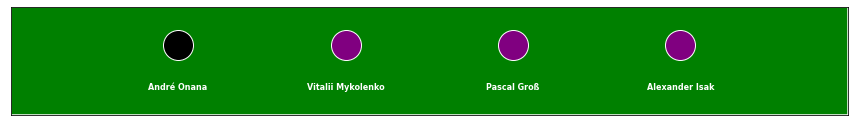

In [108]:
plot_bench(bench_lineup_df)